# Proof-of-concept: Classification of review deception via a neural network

We now wish to move on to a deep-learning approach to fake review opinion spam detection, shown in numerous papers and studies to be an effective method of classification. 
In this notebook, in a similar fashion to the other notebooks in this directory, we will use the small dataset with minimal features and set up a very basic neural network using Tensorflow and Keras.
Let's start by importing the modules we need.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import text
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


Now, let's start by getting our data. We use the get_data_frame function from the training helpers file, and split it into our X and Y (data and labels). 

It's been shown that a 70/30 train/test split is generally quite good, with a 70/30 train/validation split on the training data.

Training data is used to adjust weights, validation is used to make sure that these weight changes result in an increase in accuracy. Test data is used to run the final set of weights over data it's never seen before for final validation and to produce an accuracy.

In [2]:
from scripts import training_helpers as th
df = th.get_data_frame()

X = df['review']
y = df['deceptive']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Now let's take a look at the vocab size of our data. 

In [3]:
def find_vocab_size(reviews):
  words = set()
  for review in reviews:
    for word in review.split():
      words.add(word)
  return len(words)

print(find_vocab_size(X))

19309


This is a tonne of features, so let's use the keras Tokenizer, which lets us choose a number of the most commonly occuring words in our vocab. We'll set this number to 2000, to get rid of the least important ones, and then fit it on our data.

In [4]:
NUM_WORDS = 2000
tokenizer = text.Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(X)

Now let's define a function that takes a list of reviews and coverts it to a list of tfidf vectors based on the above dictionary.

In [5]:
def tokenize(data):
    return tokenizer.texts_to_matrix(data, mode='tfidf')

train_data = tokenize(X_train)
test_data = tokenize(X_test)

Lets take a look at these tfidf vectors and the shape of them.

In [6]:
print(train_data[0])

[0.         2.14320385 2.07090887 ... 0.         0.         0.        ]


Looks good. Now that our data is prepared, lets create our neural network.

Let's create a basic network with one hidden layer of 16 nodes, fully connected (Dense). 

The first layer needs to specify the size of the input in 'input_shape', which is the number of features in an input. Its output size will be the number of nodes passed to it. In this case, we use a very small number of nodes as it's a very small dataset, so 4 is optimal to prevent overfitting.

The following layers can infer the size.

We use the Adam optimizer, which is a replacement optimizer for stochastic gradient descent, and the binary_crossentropy loss function, which is the binary log loss function.

In [7]:
model = keras.Sequential([
    keras.layers.Dense(4, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dense(4, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
 
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 8004      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 8,029
Trainable params: 8,029
Non-trainable params: 0
_________________________________________________________________


Now let's train and validate the model. We fit it on the training data, using 70% for training (weight adjustment) and 30% for validation. Validation is important as it's data that hasn't been seen in the training, so we get a feel for how well the model generalizes and make sure overfitting does not occur. In general, how good a model is can be judged based on how low it's validation loss is.

Batch size is how many chunks we want to split out data up into. We cant pass the entire dataset in one epoch, so we split it up into chunks of size n, where n is the batch size. The number of iterations it takes to complete one epoch is the training size / batch size.

In [8]:
history = model.fit(train_data,
                      y_train,
                      epochs=12,
                      batch_size=16,
                      validation_split=0.3,
                      verbose=2)

Train on 784 samples, validate on 336 samples
Epoch 1/12
 - 2s - loss: 0.6789 - acc: 0.5651 - val_loss: 0.6542 - val_acc: 0.6012
Epoch 2/12
 - 0s - loss: 0.5512 - acc: 0.7372 - val_loss: 0.5628 - val_acc: 0.7500
Epoch 3/12
 - 0s - loss: 0.3843 - acc: 0.8929 - val_loss: 0.4782 - val_acc: 0.8036
Epoch 4/12
 - 0s - loss: 0.2268 - acc: 0.9656 - val_loss: 0.4135 - val_acc: 0.8482
Epoch 5/12
 - 0s - loss: 0.1291 - acc: 0.9860 - val_loss: 0.3844 - val_acc: 0.8571
Epoch 6/12
 - 0s - loss: 0.0803 - acc: 0.9949 - val_loss: 0.3869 - val_acc: 0.8661
Epoch 7/12
 - 0s - loss: 0.0557 - acc: 0.9962 - val_loss: 0.3883 - val_acc: 0.8661
Epoch 8/12
 - 0s - loss: 0.0408 - acc: 0.9962 - val_loss: 0.3913 - val_acc: 0.8661
Epoch 9/12
 - 0s - loss: 0.0301 - acc: 0.9974 - val_loss: 0.3977 - val_acc: 0.8631
Epoch 10/12
 - 0s - loss: 0.0222 - acc: 0.9987 - val_loss: 0.4074 - val_acc: 0.8631
Epoch 11/12
 - 0s - loss: 0.0175 - acc: 0.9987 - val_loss: 0.4207 - val_acc: 0.8512
Epoch 12/12
 - 0s - loss: 0.0144 - acc:

We can see above that the validation loss consistenly decreases as the epochs go on, and validation accuracy consistently increases. If the validation loss is decreasing up until the end, then increase the number of epochs or reduce the batch size.

From the val_acc seen at the end of every epoch, we can predict the value of accuracy on the test data. Lets evaluate the model and give it a try.

In [9]:
results = model.evaluate(test_data, y_test)
print(model.metrics_names, results)

480/480 [==============================] - 0s 133us/step
['loss', 'acc'] [0.4104764660199483, 0.8395833333333333]


Yup, the accuracy is about as predicted! And we have a pretty low loss too. This indicates a good model that will generalize well.
Let's plot the training and validation losses.

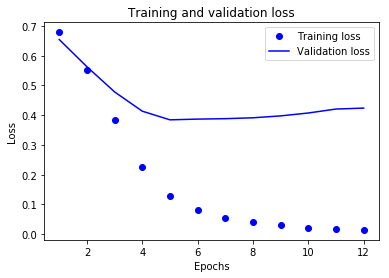

In [10]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

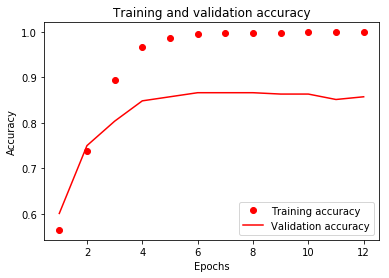

In [11]:
# "bo" is for "blue dot"
plt.plot(epochs, acc, 'ro', label='Training accuracy')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()